Please enter variables: medium.arff 1 1 1 1
Starting analysis of 4898 data points:
Number of batches: 98
Accuracy: 0.6162
Complete in 14 seconds!
Exporting results: Complete. Thank you for using this slow kNN algorithm!


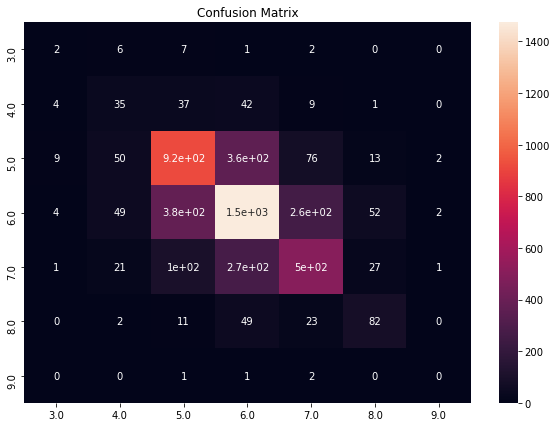

In [1]:
import math
import sys
import random
import time
import tracemalloc
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
# python Brandon_Optimized_kNN_algorithm.py small.arff 1 1 1 0
#agrs: name, k, mode, p, multi)

tracemalloc.start()

#define input variables
if len(sys.argv) < 4:
    inputs = input("Please enter variables: ").split(" ")
else:
    inputs = sys.argv[1:]

file_name = inputs[0]
k_value = int(inputs[1])
mode = inputs[2]

if mode == "1" or mode == "2" or mode == "3":
    mode = int(mode)
elif mode == "euclidian":
    mode = 1
elif mode == "manhattan":
    mode = 2
elif mode == "minkowski":
    mode = 3
else:
    print("Mode name invalid, going to default.")
    mode = 1

p_value = 1
try:
    p_value = float(inputs[3])
except:
    print("", end="")

multi = False
try:
    multi = (1 == float(inputs[4]))
except:
    print("", end="")

#create distance functions
def euclidian(point1, point2):
    total_distance = 0
    for i in range(len(point1)-1):
        total_distance += (float(point1[i]) - float(point2[i])) ** 2
    return math.sqrt(total_distance)
def manhattan(point1, point2):
    total_distance = 0
    for d in range(len(point1) - 2):
        total_distance += abs(float(point1[d]) - float(point2[d]))
    return total_distance

def minkowski(point1, point2, p):
    total_distance = 0
    for i in range(len(point1) - 2):
        total_distance += (abs(float(point1[i]) - float(point2[i])))**p
    return total_distance ** (1/p)

def majority(lst):
    counter = 0
    num = lst[0]

    for i in lst:
        cur_count = lst.count(i)
        if (cur_count > counter):
            counter = cur_count
            num = i
    return num


start = time.time()

def kNN(file_name, k, mode, p_value=1):
    global multi
    correct = 0
    wrong = 0

    #check file name
    try:
        input_file = open(file_name, "r")
    except:
        print("File name incorrect!")
        sys.exit()

    #create data array
    Lines = input_file.readlines()
    data = []
    for l in Lines:
        if l[0] != "@":
            line = l.strip("\n").split(",")
            data.append(line)

    #ask about multiprocessing
    if len(data) > 500 and multi == False:
        multi_question = input("The data is very large and would take over a minute, would you like to employ multiprocessing? (y/n)")
        if multi_question == "y":
            multi = True
    
    print("Starting analysis of", len(data), "data points:")
    if multi == False:
        actual_classes = []
        guesses = []
        for predict in data:
            actual_classes.append(predict[-1])
            
            distances = [9999999999999999] * k
            classes = [9999999999999999] * k
            highest = max(distances)
            taken = False
            for point in data:
                if point != predict or taken == True:
                    if mode == 1:
                        distance = euclidian(predict, point)
                    elif mode == 2:
                        distance = manhattan(predict, point)
                    elif mode == 3:
                        distance = minkowski(predict, point, p_value)
                    else:
                        print("Invalid mode!a")
                        sys.exit()

                    if distance < highest:
                        classes.pop(distances.index(highest))
                        distances.remove(highest)
                        distances.append(distance)
                        classes.append(point[-1])
                        highest = max(distances)
                else:
                    taken = True
            guess = majority(classes)
            if predict[-1] == guess:
                correct += 1
            else:
                wrong += 1
            guesses.append(guess)
    else:
        import multiprocessing
        from multiprocessing import Pool
        import kNN_multi
        
        actual_classes = []
        for predict in data:
            actual_classes.append(predict[-1])

        batch_size = 50
        count = 0
        population = []
        for i in range(int(len(data)/batch_size) + 1):
            try:
                current = [i * batch_size, (i+1) * batch_size, file_name, k, mode, p_value]
                population.append(current)
            except:
                current = [i * batch_size, len(data), file_name, k, mode, p_value]
                population.append(current)
        print("Number of batches:", len(population))
        #sys.exit()
        if __name__ == '__main__':
            pool = Pool()
            batch_guesses = pool.map(kNN_multi.kNN, population)
        guesses = []
        for batch in batch_guesses:
            for g in batch:
                guesses.append(g)
    return guesses, actual_classes

predictions, actual_classes = kNN(file_name, k_value, mode, p_value)

#create list of all unique actual classes for use in creating confusion matrix
total_classes = []

for x in actual_classes:
    if total_classes.count(float(x)) == 0:
        total_classes.append(float(x))
total_classes.sort()
#print("total classes length:", len(total_classes))

#Create confusion matrix data
confusion_matrix = []
for c in total_classes:
    confusion_matrix.append([0] * len(total_classes))
    
differences = []
squared_differences = []
corrects = 0
wrongs = 0

t = 0
for p in predictions:
    predicted_class = total_classes.index(float(p))
    actual_class = total_classes.index(float(actual_classes[t]))

    confusion_matrix[predicted_class][actual_class] += 1

    if predicted_class == actual_class:
        corrects += 1
    else:
        wrongs += 1
    differences.append(abs(actual_class - predicted_class))
    squared_differences.append((abs(actual_class - predicted_class))**2)

    t += 1

print("Accuracy:", format(corrects/(wrongs + corrects), "0.4f"))
end = time.time()
total_time = end-start
print("Complete in", int(total_time), "seconds!")

horizontal_matrix = []
for i in range(len(confusion_matrix)):
    current = []
    for x in confusion_matrix:
        current.append(x[i])
    horizontal_matrix.append(current)
print("Exporting results: ", end="")
#create(confusion_matrix)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in total_classes],
                  columns = [i for i in total_classes])

plt.figure(figsize = (10,7))
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
sn.heatmap(df_cm, annot=True)
plt.savefig("kNN_Confusion_Matrix.png")

#create and save other data
file = open("kNN_output.txt", "w")
if mode == 1:
    distance_name = "euclidian"
elif mode == 2:
    distance_name = "manhattan"
elif mode == 3:
    distance_name = "minkowski"
else:
    distance_name = "unknown"
file.write("kNN analysis on: " + file_name + " with " + str(len(predictions)) + " data points using " + distance_name + " distance calculation\n")
file.write("General Metrics: \n")
sig = "0.3f"
accuracy = corrects / (corrects + wrongs)
mean_absolute_error = sum(differences) / len(differences)
mean_squared_error = sum(squared_differences) / len(squared_differences)
file.write("Execution time: " + str(int(total_time)) + " seconds\n")
file.write("Peak Memory Usage: " + str(int(tracemalloc.get_traced_memory()[1]/1000000)) + " MB\n")
file.write("Accuracy:" + format(accuracy, sig) + "\n")
file.write("Mean absolute error:" + format(mean_absolute_error, sig) + "\n")
file.write("Mean squared error: " + format(mean_squared_error, sig) +  "\n" + "\n")
#calculate for each class:
#Precision, Recall, F1 score
class_metrics = []

group_num = 0
t = 0
for x in confusion_matrix:
    file.write("Metrics for " + str(total_classes[group_num]) + ":\n")
    true_posistives = x[group_num]
    false_posistives = sum(x) - true_posistives
    true_negatives = len(predictions) - (false_posistives + sum(x))
    false_negatives = sum(horizontal_matrix[t]) - true_posistives

    try:
        precision = format((true_posistives) / (true_posistives + false_posistives), sig)
    except:
        precision = "N/A"
    try:
        recall = format(true_posistives / (true_posistives + false_negatives), sig)
    except:
        recall = "N/A"
    try:
        f1_score = format(2 / ((1/float(recall)) * (1/float(precision))), sig)
    except:
        f1_score = "N/A"
    try:
        sensitivity = format(true_posistives / (true_posistives + false_negatives), sig)
    except:
        sensitivity = "N/A"
    try:
        specificity = format(true_negatives / (true_negatives + false_posistives), sig)
    except:
        specificity = "N/A"

    file.write("Precision: " + precision + "\n")
    file.write("Recall: " + recall + "\n")
    file.write("F1 score: " + f1_score + "\n")
    file.write("Sensitivity:" + sensitivity + "\n")
    file.write("Specificity:" + specificity + "\n")
    file.write("\n")

    group_num += 1
    t += 1

print("Complete. Thank you for using this slow kNN algorithm!")
file.close()
tracemalloc.stop()